In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
dataset_path = Path("/kaggle/input/deepweeds")
images = list(dataset_path.glob(r"**/*.jpg"))
file_names = list(map(lambda x: x.name, images))

In [5]:
images = pd.Series(images, name="Images").astype(str)
files = pd.Series(file_names, name="Filename").astype(str)
_data_ = pd.concat([images, files], axis=1)

data = pd.read_csv(Path(dataset_path, "labels/labels.csv"))
data = data.set_index('Filename').join(_data_.set_index('Filename'), on='Filename', how='inner')
data = data.sample(frac = 1, random_state = 42)
data.head()

,Label,Species,Images
Filename,,,
20180109-095809-1.jpg,8,Negative,/kaggle/input/deepweeds/images/20180109-095809...
20180322-133358-1.jpg,8,Negative,/kaggle/input/deepweeds/images/20180322-133358...
20171122-101153-1.jpg,5,Rubber vine,/kaggle/input/deepweeds/images/20171122-101153...
20171220-091406-2.jpg,8,Negative,/kaggle/input/deepweeds/images/20171220-091406...
20171219-113243-2.jpg,8,Negative,/kaggle/input/deepweeds/images/20171219-113243...


/tmp/ipykernel_47/3675026844.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.imshow(imageio.imread(data.Images[i]))
/tmp/ipykernel_47/3675026844.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(data.Images[i]))
/tmp/ipykernel_47/3675026844.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_title(data.Species[i])


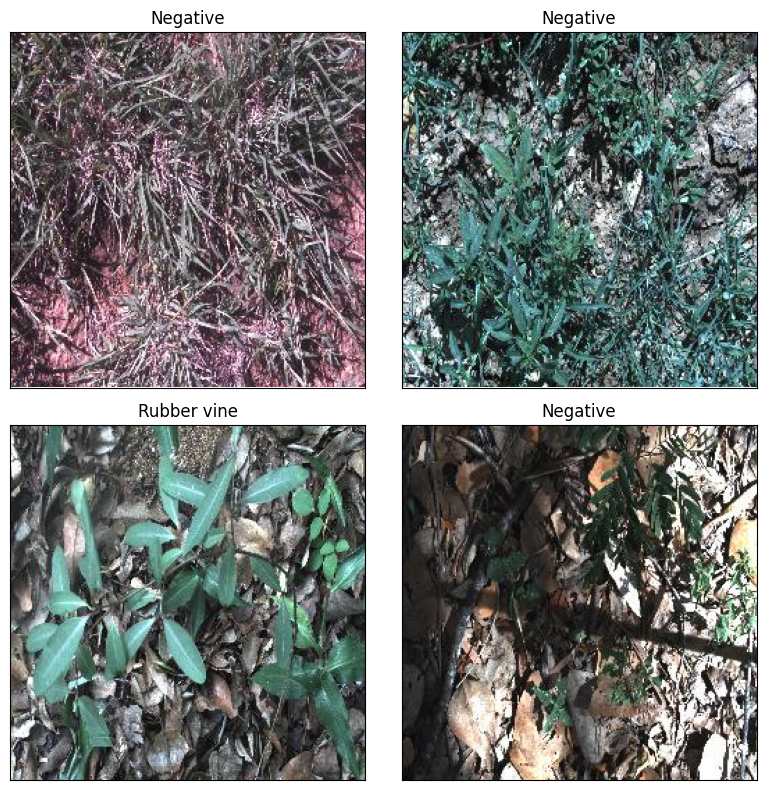

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(imageio.imread(data.Images[i]))
  ax.set_title(data.Species[i])
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet

train_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input,
    validation_split = 0.1
)

test_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input
)

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, train_size=0.9, shuffle=True, random_state=42, stratify=data[['Species']])

train = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Species",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

validation = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Species",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5,1.5],
    sheer_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

test = test_generator_eff_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Species",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Found 14183 validated image filenames belonging to 9 classes.
Found 1575 validated image filenames belonging to 9 classes.
Found 1751 validated image filenames belonging to 9 classes.


In [9]:
basemodel = efficientnet.EfficientNetB0(
                                          include_top=False,
                                          weights='imagenet',
                                          input_shape=(224,224,3), 
                                          pooling='avg',
                                        )
# basemodel.summary()
basemodel.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [10]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(1024, activation='relu')(basemodel.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(9, activation='softmax')(x)

eff = Model(inputs=basemodel.inputs, outputs=outputs)

In [11]:
eff.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [12]:
CHECKPOINTS = Path("./checkpoints")
CHECKPOINTS.mkdir(exist_ok=True)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# training
results = eff.fit(
    train,
    validation_data = validation,
    batch_size = 32,
    epochs = 40,
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(patience=2),
        ModelCheckpoint(
        str(CHECKPOINTS),
        monitor="val_loss",
        save_best_only=True)
    ]
)

Epoch 1/40


2023-12-07 20:33:22.752750: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


444/444 [==============================] - 108s 212ms/step - loss: 0.8547 - categorical_accuracy: 0.7160 - val_loss: 0.5088 - val_categorical_accuracy: 0.8279 - lr: 0.0010
Epoch 2/40
444/444 [==============================] - 36s 80ms/step - loss: 0.5313 - categorical_accuracy: 0.8277 - val_loss: 0.5101 - val_categorical_accuracy: 0.8165 - lr: 0.0010
Epoch 3/40
444/444 [==============================] - 61s 138ms/step - loss: 0.4137 - categorical_accuracy: 0.8661 - val_loss: 0.4668 - val_categorical_accuracy: 0.8419 - lr: 0.0010
Epoch 4/40
444/444 [==============================] - 59s 132ms/step - loss: 0.3479 - categorical_accuracy: 0.8852 - val_loss: 0.4620 - val_categorical_accuracy: 0.8610 - lr: 0.0010
Epoch 5/40
444/444 [==============================] - 60s 136ms/step - loss: 0.3109 - categorical_accuracy: 0.8950 - val_loss: 0.4204 - val_categorical_accuracy: 0.8724 - lr: 0.0010
Epoch 6/40
444/444 [==============================] - 35s 78ms/step - loss: 0.2636 - categorical_accu

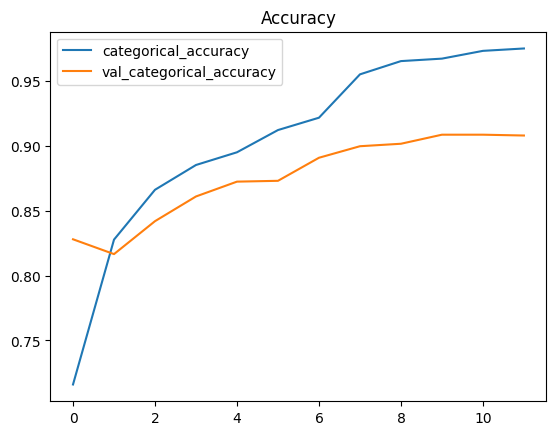

In [14]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

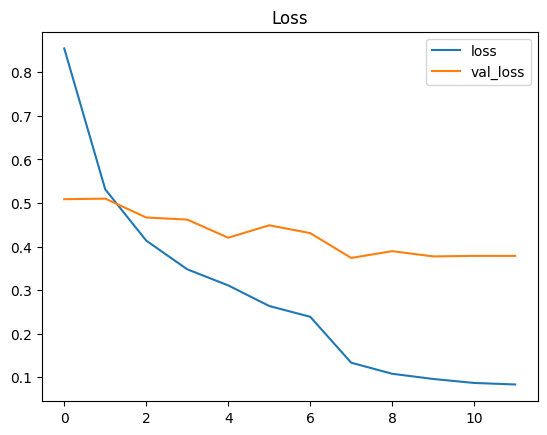

In [15]:
pd.DataFrame(results.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [16]:
def unfreeze(model, layer_cc):
    for layer in model.layers[-layer_cc:]:
        layer.trainable = True

# basemodel.trainable = True

# fine_tune = 100

for i, layer in enumerate(basemodel.layers[:]):
    print(i, layer)
#     layer.trainable =  False

0 <keras.src.engine.input_layer.InputLayer object at 0x7ec27cf306a0>
1 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7ec27cf315a0>
2 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7ec27cf31120>
3 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7ec27cf30b50>
4 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ec27cf30af0>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ec27d2e7100>
6 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ec27d2e6ec0>
7 <keras.src.layers.core.activation.Activation object at 0x7ec27d2e5bd0>
8 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7ec27d568f40>
9 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ec27d2e5900>
10 <keras.src.layers.core.activation.Activation object at 0x7ec27c418c70>
11 <keras.src.layers.pooling.global_average_pooling2d.GlobalAverag

In [17]:
init_epoch = results.epoch[-1] + 1

for cc in [30, 60, 100, 150]:
    
    CHECKPOINTS_FINETUNE = Path(f"./checkpoints-fine-tune-{cc}")
    CHECKPOINTS_FINETUNE.mkdir(exist_ok=True)
    
    print(f"---- cc: {cc} ----")
    
    unfreeze(basemodel, cc)
    
    eff.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )
    epoch = init_epoch + 20
    
    results_finetune = eff.fit(
        train,
        validation_data = validation,
        batch_size = 32,
        epochs = epoch,
        initial_epoch = init_epoch,
        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=5,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(patience=2),
            ModelCheckpoint(
            str(CHECKPOINTS),
            monitor="val_loss",
            save_best_only=True)
        ]
    )
    
    np.save(f'model_history_fine_tune-{cc}.npy',results_finetune.history)
    init_epoch = results_finetune.epoch[-1] + 1
    

---- cc: 30 ----
Epoch 13/32


2023-12-07 20:43:15.042681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


444/444 [==============================] - 76s 142ms/step - loss: 0.5603 - categorical_accuracy: 0.8306 - val_loss: 0.3946 - val_categorical_accuracy: 0.8781 - lr: 0.0010
Epoch 14/32
444/444 [==============================] - 62s 139ms/step - loss: 0.3082 - categorical_accuracy: 0.9022 - val_loss: 0.3051 - val_categorical_accuracy: 0.9105 - lr: 0.0010
Epoch 15/32
444/444 [==============================] - 35s 79ms/step - loss: 0.2393 - categorical_accuracy: 0.9264 - val_loss: 0.3300 - val_categorical_accuracy: 0.9035 - lr: 0.0010
Epoch 16/32
444/444 [==============================] - 63s 142ms/step - loss: 0.2090 - categorical_accuracy: 0.9370 - val_loss: 0.2974 - val_categorical_accuracy: 0.9124 - lr: 0.0010
Epoch 17/32
444/444 [==============================] - 64s 144ms/step - loss: 0.1918 - categorical_accuracy: 0.9415 - val_loss: 0.2467 - val_categorical_accuracy: 0.9200 - lr: 0.0010
Epoch 18/32
444/444 [==============================] - 36s 81ms/step - loss: 0.1675 - categorical_

2023-12-07 20:54:33.837149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


444/444 [==============================] - 82s 151ms/step - loss: 0.2620 - categorical_accuracy: 0.9239 - val_loss: 0.3468 - val_categorical_accuracy: 0.9079 - lr: 0.0010
Epoch 28/46
444/444 [==============================] - 64s 143ms/step - loss: 0.1891 - categorical_accuracy: 0.9444 - val_loss: 0.2419 - val_categorical_accuracy: 0.9321 - lr: 0.0010
Epoch 29/46
444/444 [==============================] - 34s 77ms/step - loss: 0.1550 - categorical_accuracy: 0.9553 - val_loss: 0.3060 - val_categorical_accuracy: 0.9137 - lr: 0.0010
Epoch 30/46
444/444 [==============================] - 34s 77ms/step - loss: 0.1362 - categorical_accuracy: 0.9583 - val_loss: 0.3445 - val_categorical_accuracy: 0.9130 - lr: 0.0010
Epoch 31/46
444/444 [==============================] - 63s 141ms/step - loss: 0.0719 - categorical_accuracy: 0.9808 - val_loss: 0.1976 - val_categorical_accuracy: 0.9441 - lr: 1.0000e-04
Epoch 32/46
444/444 [==============================] - 34s 76ms/step - loss: 0.0351 - categoric

2023-12-07 21:02:02.432186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


444/444 [==============================] - 86s 146ms/step - loss: 0.2865 - categorical_accuracy: 0.9184 - val_loss: 0.4679 - val_categorical_accuracy: 0.8927 - lr: 0.0010
Epoch 38/56
444/444 [==============================] - 62s 140ms/step - loss: 0.1931 - categorical_accuracy: 0.9420 - val_loss: 0.2839 - val_categorical_accuracy: 0.9206 - lr: 0.0010
Epoch 39/56
444/444 [==============================] - 63s 143ms/step - loss: 0.1492 - categorical_accuracy: 0.9538 - val_loss: 0.2610 - val_categorical_accuracy: 0.9308 - lr: 0.0010
Epoch 40/56
444/444 [==============================] - 63s 142ms/step - loss: 0.1257 - categorical_accuracy: 0.9626 - val_loss: 0.2265 - val_categorical_accuracy: 0.9403 - lr: 0.0010
Epoch 41/56
444/444 [==============================] - 35s 79ms/step - loss: 0.1308 - categorical_accuracy: 0.9636 - val_loss: 0.2791 - val_categorical_accuracy: 0.9276 - lr: 0.0010
Epoch 42/56
444/444 [==============================] - 35s 78ms/step - loss: 0.1230 - categorical_

2023-12-07 21:12:51.489076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


444/444 [==============================] - 101s 161ms/step - loss: 0.2325 - categorical_accuracy: 0.9333 - val_loss: 0.3764 - val_categorical_accuracy: 0.9060 - lr: 0.0010
Epoch 51/69
444/444 [==============================] - 40s 91ms/step - loss: 0.1644 - categorical_accuracy: 0.9527 - val_loss: 0.4045 - val_categorical_accuracy: 0.9098 - lr: 0.0010
Epoch 52/69
444/444 [==============================] - 71s 160ms/step - loss: 0.1712 - categorical_accuracy: 0.9514 - val_loss: 0.3255 - val_categorical_accuracy: 0.9130 - lr: 0.0010
Epoch 53/69
444/444 [==============================] - 40s 91ms/step - loss: 0.1138 - categorical_accuracy: 0.9667 - val_loss: 0.3316 - val_categorical_accuracy: 0.9251 - lr: 0.0010
Epoch 54/69
444/444 [==============================] - 40s 91ms/step - loss: 0.1074 - categorical_accuracy: 0.9693 - val_loss: 0.4856 - val_categorical_accuracy: 0.9060 - lr: 0.0010
Epoch 55/69
444/444 [==============================] - 70s 158ms/step - loss: 0.0478 - categorical_

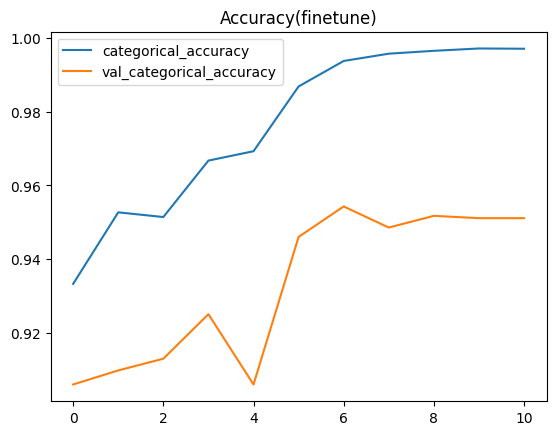

In [18]:
pd.DataFrame(results_finetune.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy(finetune)")
plt.show()

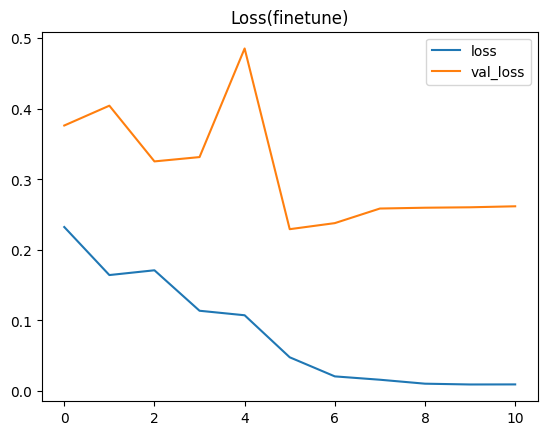

In [19]:
pd.DataFrame(results_finetune.history)[['loss', 'val_loss']].plot()
plt.title("Loss(finetune)")
plt.show()

In [20]:
MODEL_PATH = Path("./saved_model")
MODEL_PATH.mkdir(exist_ok=True)
eff.save(str(MODEL_PATH))

In [21]:

model_path = Path("./checkpoints/model.h5")

# Save the model to the specified path
eff.save(model_path)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
np.save('model_history.npy',results.history)

In [23]:
results = eff.evaluate(test)

55/55 [==============================] - 9s 168ms/step - loss: 0.2959 - categorical_accuracy: 0.9486


In [24]:
predictions = np.argmax(eff.predict(test), axis=1)

55/55 [==============================] - 5s 66ms/step


In [25]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Species)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

                precision    recall  f1-score   support

  Chinee apple       0.88      0.87      0.88       113
       Lantana       0.95      0.92      0.94       106
      Negative       0.97      0.97      0.97       911
   Parkinsonia       0.91      0.93      0.92       103
    Parthenium       0.94      0.93      0.94       102
Prickly acacia       0.89      0.96      0.93       106
   Rubber vine       0.94      0.92      0.93       101
     Siam weed       0.96      0.96      0.96       107
    Snake weed       0.91      0.89      0.90       102

      accuracy                           0.95      1751
     macro avg       0.93      0.93      0.93      1751
  weighted avg       0.95      0.95      0.95      1751



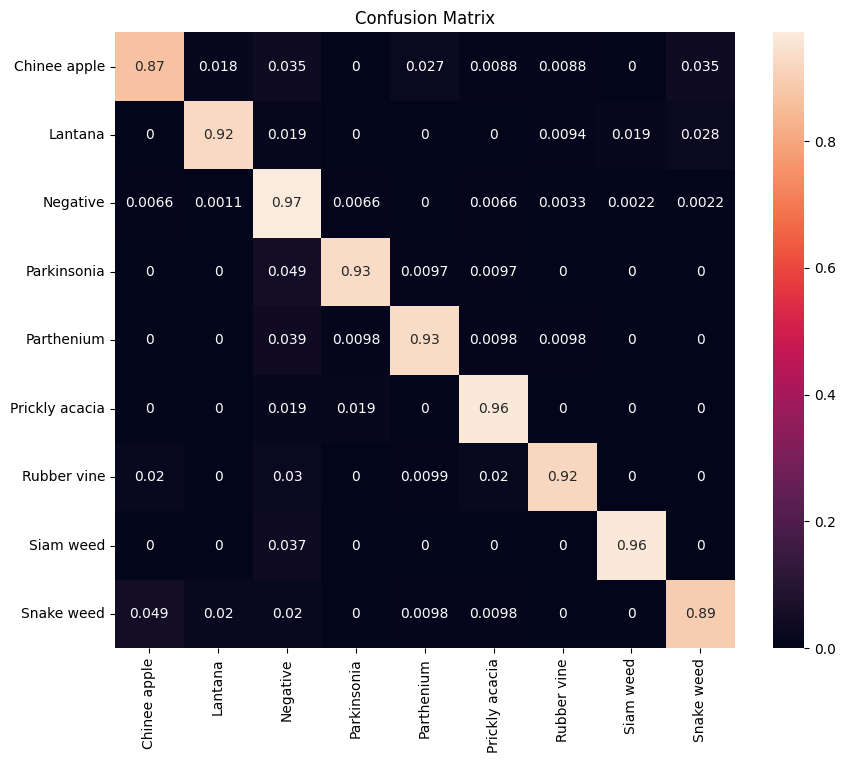

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()

In [27]:
cd saved_model

/kaggle/working/saved_model
